In [2]:
import numpy as np
import pickle
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

%matplotlib inline
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')
import scripts.map_and_average as mapper
import scripts.util_feature_learning as util_feature_learning

## Load data

In [2]:
trainset, valset, testset = mapper.load_train_val_test_sets()
traindata, trainlabels, trainaudiolabels = trainset
valdata, vallabels, valaudiolabels = valset
testdata, testlabels, testaudiolabels = testset
labels = np.concatenate((trainlabels, vallabels, testlabels)).ravel()
audiolabels = np.concatenate((trainaudiolabels, valaudiolabels, testaudiolabels)).ravel()
print traindata.shape, valdata.shape, testdata.shape

/import/c4dm-04/mariap/train_data_melodia_8.pickle
(325435, 840) (106632, 840) (107083, 840)


## explain LDA

mapping rhy
training with PCA transform...
variance explained 1.0
138 400
training with PCA transform...
variance explained 0.990092414237
training with LDA transform...
variance explained 1.0
done fitting
mapping mel
training with PCA transform...
variance explained 1.0
214 240
training with PCA transform...
variance explained 0.990298772177
training with LDA transform...
variance explained 1.0
done fitting
mapping mfc
training with PCA transform...
variance explained 1.0
39 80
training with PCA transform...
variance explained 0.991435457701
training with LDA transform...
variance explained 0.962216871623
done fitting
mapping chr
training with PCA transform...
variance explained 1.0
69 120
training with PCA transform...
variance explained 0.989979139207
training with LDA transform...
variance explained 0.96455301758
done fitting


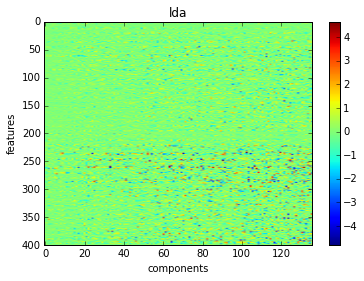

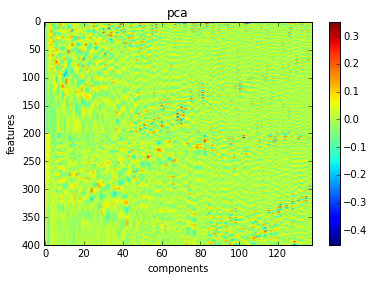

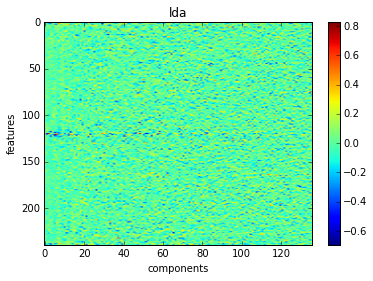

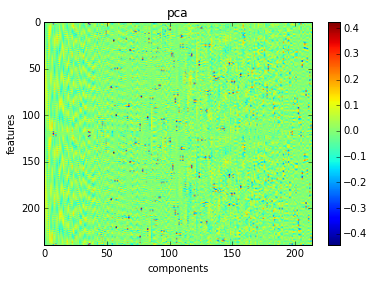

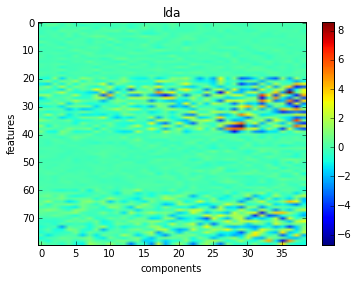

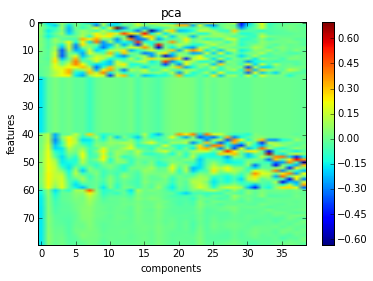

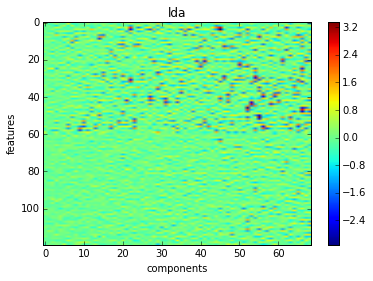

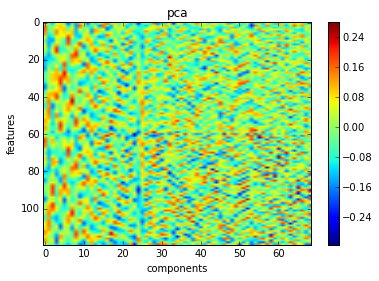

In [14]:
min_variance = 0.99
feat_labels, feat_inds = mapper.get_feat_inds(n_dim=traindata.shape[1])
for i in range(len(feat_inds)):
    print "mapping " + feat_labels[i]
    inds = feat_inds[i]
    ssm_feat = util_feature_learning.Transformer()
    if min_variance is not None:
        ssm_feat.fit_data(traindata[:, inds], trainlabels, n_components=len(inds), pca_only=True)
        n_components = np.where(ssm_feat.pca_transformer.explained_variance_ratio_.cumsum()>min_variance)[0][0]+1
        print n_components, len(inds)
        ssm_feat.fit_lda_data(traindata[:, inds], trainlabels.ravel(), n_components=n_components)
        print "done fitting"
        WW = ssm_feat.lda_transformer.scalings_
        plt.figure()
        plt.imshow(WW[:, :n_components], aspect='auto')
        plt.colorbar()
        plt.title('lda')
        plt.xlabel('components')
        plt.ylabel('features')
        plt.savefig('../data/lda_'+feat_labels[i]+'.pdf')
        
        WW = ssm_feat.pca_transformer.components_.T
        plt.figure()
        plt.imshow(WW[:, :n_components], aspect='auto')
        plt.colorbar()
        plt.title('pca')
        plt.xlabel('components')
        plt.ylabel('features')
        plt.savefig('../data/pca_'+feat_labels[i]+'.pdf')

## export figure for LDA, PCA timbral components

In [ ]:
i = 3
print "mapping " + feat_labels[i]
inds = feat_inds[i]
ssm_feat = util_feature_learning.Transformer()
if min_variance is not None:
    ssm_feat.fit_data(traindata[:, inds], trainlabels, n_components=len(inds), pca_only=True)
    n_components = np.where(ssm_feat.pca_transformer.explained_variance_ratio_.cumsum()>min_variance)[0][0]+1
    print n_components, len(inds)
    ssm_feat.fit_lda_data(traindata[:, inds], trainlabels.ravel(), n_components=n_components)
    print "done fitting"
    WW = ssm_feat.lda_transformer.scalings_
    plt.figure()
    plt.imshow(WW[:, :n_components], aspect='auto')
    plt.colorbar()
    plt.title('lda')
    plt.xlabel('components')
    plt.ylabel('features')
    y_loc = np.arange(10, 80, 20)
    y_labs = ['mean(MFCC), mean(DELTA), std(MFCC), std(DELTA)']
    plt.yticks(y_loc, y_labs, rotation='vertical')
    plt.savefig('../data/lda_'+feat_labels[i]+'.pdf')

    WW = ssm_feat.pca_transformer.components_.T
    plt.figure()
    plt.imshow(WW[:, :n_components], aspect='auto')
    plt.colorbar()
    plt.title('pca')
    plt.xlabel('components')
    plt.ylabel('features')
    y_loc = np.arange(10, 80, 20)
    y_labs = ['mean(MFCC), mean(DELTA), std(MFCC), std(DELTA)']
    plt.yticks(y_loc, y_labs, rotation='vertical')
    plt.savefig('../data/pca_'+feat_labels[i]+'.pdf')

## explain classifier

In [5]:
X_list, Y, Yaudio = pickle.load(open('../data/lda_data_melodia_8.pickle','rb'))
X = np.concatenate(X_list, axis=1)
print X.shape

(8200, 380)


## split train/test sets for classifier same as train/test sets of LDA transformer

In [6]:
# train, test indices
aa_train = np.unique(trainaudiolabels)
aa_test = np.unique(testaudiolabels)
traininds = np.array([i for i, item in enumerate(Yaudio) if item in aa_train])
testinds = np.array([i for i, item in enumerate(Yaudio) if item in aa_test])
X_train, Y_train = X[traininds, :], Y[traininds]
X_test, Y_test = X[testinds, :], Y[testinds]

In [7]:
print traininds.shape, testinds.shape
#print np.unique(Y_train), np.unique(Y_test)

(4916,) (1635,)


In [8]:
ssm_feat = util_feature_learning.Transformer()
ssm_feat.classify(X_train, Y_train, X_test, Y_test)

/homes/mp305/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


KNN   0.142386106377
LDA   0.191960555979
SVM   0.0505670728027
RF   0.0777665088464


0         1
0  KNN  0.142386
0  LDA  0.191961
0  SVM  0.050567
0   RF  0.077767

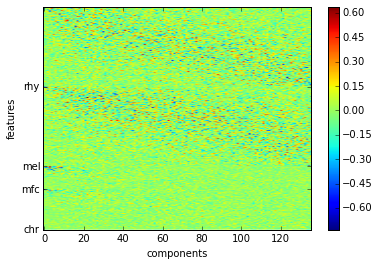

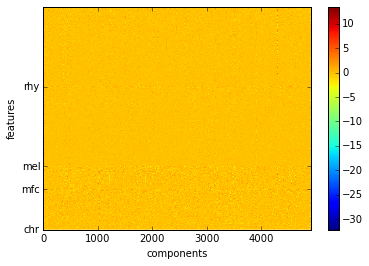

In [12]:
classifier_WW = ssm_feat.modelLDA.scalings_
plt.figure()
plt.imshow(classifier_WW, aspect='auto')
feat_lens = np.array([X_list[i].shape[1] for i in range(len(X_list))])
#plt.yticks(np.cumsum(feat_lens), ['rhy', 'mel', 'mfc', 'chr']);
plt.colorbar()
plt.xlabel('components')
plt.ylabel('features')
boundaries = np.concatenate([[0], np.cumsum(feat_lens)])
y_loc = np.diff(boundaries) / 2.0 + boundaries[:-1]
y_labs = ['rhythm', 'melody', 'timbre', 'harmony']
plt.yticks(y_loc, y_labs, rotation='vertical')
plt.savefig('../data/pca_'+feat_labels[i]+'.pdf')


classifier_WW = ssm_feat.modelSVM.support_vectors_.T
plt.figure()
plt.imshow(classifier_WW, aspect='auto')
feat_lens = np.array([X_list[i].shape[1] for i in range(len(X_list))])
plt.yticks(np.cumsum(feat_lens), ['rhy', 'mel', 'mfc', 'chr']);
plt.colorbar()
plt.xlabel('components')
plt.ylabel('features')

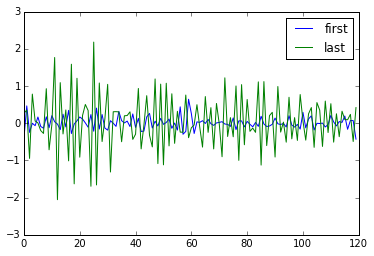

In [26]:
plt.plot(WW[:, 0].T)
plt.plot(WW[:, -1].T)
plt.legend(['first', 'last'])

In [31]:
ssm_feat.lda_transformer.explained_variance_ratio_

array([ 0.14373482,  0.08618908,  0.06204185,  0.05570435,  0.04295312,
        0.03662191,  0.0307794 ,  0.02747614,  0.02537898,  0.02135531,
        0.0198002 ,  0.01780429,  0.01768059,  0.01589127,  0.01577824,
        0.01509926,  0.01438677,  0.01375288,  0.01325775,  0.01276577,
        0.01233942,  0.01141807,  0.01101174,  0.01063879,  0.01020333,
        0.0100233 ,  0.00934799,  0.00928772,  0.00900632,  0.00843197,
        0.00810172,  0.00777747,  0.00750705,  0.00731203,  0.00712737,
        0.00671856,  0.00666916,  0.0063888 ,  0.00596438,  0.00573898,
        0.00569793,  0.00547815,  0.00531844,  0.00519665,  0.00504727,
        0.00484002,  0.00463841,  0.0044623 ,  0.00430168,  0.00412414,
        0.00410127,  0.0039772 ,  0.00377142,  0.00370609,  0.00350547,
        0.00339721,  0.0033434 ,  0.00327321,  0.00300821,  0.00278651,
        0.00264507,  0.00256565,  0.00252508,  0.00238254,  0.00235638,
        0.00231017,  0.00221235,  0.00210712,  0.00200755])

In [33]:
ssm_feat.lda_transformer.scalings_.shape

(120, 120)